In [1]:
import pandas as pd 
import numpy as np
import os, shutil
#import cv2
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Flatten, Convolution2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.metrics import Recall as recall
from keras import layers, models
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt
%matplotlib inline

### Business Problem

### Shutil images

The kaggle dataset has more then 89% of the images in the train set, 10 % in the test and only 0.3% in the validation, so I will move some of the images from the train folder to the test and validation, to get 70-20-10% split between them.

In [2]:
train_p = "data/chest_xray/train/PNEUMONIA"
train_n = "data/chest_xray/train/NORMAL"
test_p = "data/chest_xray/test/PNEUMONIA"
test_n = "data/chest_xray/test/NORMAL"
val_p = "data/chest_xray/val/PNEUMONIA"
val_n = "data/chest_xray/val/NORMAL"

In [3]:
#images_p = [file for file in os.listdir(train_p) if file.endswith('.jpeg')]

In [4]:
#images_n = [file for file in os.listdir(train_n) if file.endswith('.jpeg')]

In [5]:
# checking images
#images_p[0:10]

In [6]:
#test images pneumonia shutil
#imgs_pneumonia = images_p[:404]
#for img in imgs_pneumonia:
#    origin = os.path.join(train_p, img)
#    destination = os.path.join(test_p, img)
#    shutil.move(origin, destination)

In [7]:
# test images normal shutil
#imgs_normal = images_n[:206]
#for img in imgs_normal:
#    origin = os.path.join(train_n, img)
#    destination = os.path.join(test_n, img)
#    shutil.move(origin, destination)
    

In [8]:
# validation images pneumonia shutil
#imgs_pneumonia = images_p[404:825]
#for img in imgs_pneumonia:
#    origin = os.path.join(train_p, img)
#    destination = os.path.join(val_p, img)
#    shutil.move(origin, destination)

In [9]:
# validation images normal shutil
#imgs_normal = images_n[206:490]
#for img in imgs_normal:
#    origin = os.path.join(train_n, img)
#    destination = os.path.join(val_n, img)
#    shutil.move(origin, destination)

### Preprocessing

In [10]:
train_path = "data/chest_xray/train"
test_path = "data/chest_xray/test"
val_path = "data/chest_xray/val"

In [11]:
# normalizing the images
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
# intentiating the generator
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(200,200),
    batch_size = 3901,
    color_mode = 'grayscale',
    class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(
    test_path, 
    target_size = (200, 200),
    batch_size = 1234,
    color_mode = 'grayscale',
    class_mode = 'categorical')

val_generator = test_datagen.flow_from_directory(
    val_path, 
    target_size = (200, 200),
    batch_size = 721,
    color_mode = 'grayscale',
    class_mode = 'categorical')

Found 3901 images belonging to 2 classes.
Found 1234 images belonging to 2 classes.
Found 721 images belonging to 2 classes.


In [13]:
#train_class_names = list(train_generator.class_indices.keys())
#train_class_names

In [14]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [15]:
# Explore the dataset
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
#print ("train_images shape: " + str(train_images.shape))
#print ("train_labels shape: " + str(train_labels.shape))
#print ("test_images shape: " + str(test_images.shape))
#print ("test_labels shape: " + str(test_labels.shape))
#print ("val_images shape: " + str(val_images.shape))
#print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 3901
Number of testing samples: 1234
Number of validation samples: 721


In [16]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(3901, 40000)
(1234, 40000)
(721, 40000)


In [17]:
train_y = np.reshape(train_labels[:,0], (3901,1))
test_y = np.reshape(test_labels[:,0], (1234,1))
val_y = np.reshape(val_labels[:,0], (721,1))

In [18]:
model1 = models.Sequential()
model1.add(Dense(20, activation='relu', input_shape = (40000,)))
model1.add(Dense(7, activation = 'relu'))
model1.add(Dense(5, activation = 'relu'))
model1.add(Dense(1, activation = 'sigmoid'))

Metal device set to: Apple M1 Max


2022-12-07 10:30:56.960333: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-07 10:30:56.960477: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [19]:
model1.compile(optimizer = 'sgd',
             loss = 'binary_crossentropy',
             metrics = [recall()])

history = model1.fit(train_img,
                   train_y,
                   epochs = 150,
                   batch_size = 32,
                   validation_data = (val_img, val_y))

Epoch 1/150


2022-12-07 10:30:57.182532: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-07 10:30:57.327376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


122/122 [==============================] - ETA: 0s - loss: 0.5059 - recall: 0.0000e+00

2022-12-07 10:30:59.360730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


122/122 [==============================] - 3s 18ms/step - loss: 0.5059 - recall: 0.0000e+00 - val_loss: 0.5409 - val_recall: 0.0000e+00
Epoch 2/150
122/122 [==============================] - 2s 18ms/step - loss: 0.4056 - recall: 0.2691 - val_loss: 0.4477 - val_recall: 0.8493
Epoch 3/150
122/122 [==============================] - 2s 17ms/step - loss: 0.3647 - recall: 0.5206 - val_loss: 0.4377 - val_recall: 0.9007
Epoch 4/150
122/122 [==============================] - 2s 17ms/step - loss: 0.3266 - recall: 0.6052 - val_loss: 0.4024 - val_recall: 0.8973
Epoch 5/150
122/122 [==============================] - 2s 17ms/step - loss: 0.3155 - recall: 0.6710 - val_loss: 0.3760 - val_recall: 0.7842
Epoch 6/150
122/122 [==============================] - 2s 17ms/step - loss: 0.3159 - recall: 0.6675 - val_loss: 0.3602 - val_recall: 0.8801
Epoch 7/150
122/122 [==============================] - 2s 17ms/step - loss: 0.2995 - recall: 0.7074 - val_loss: 0.4092 - val_recall: 0.6781
Epoch 8/150
122/122 [===

122/122 [==============================] - 2s 17ms/step - loss: 0.2053 - recall: 0.7908 - val_loss: 0.2165 - val_recall: 0.8870
Epoch 60/150
122/122 [==============================] - 2s 17ms/step - loss: 0.2048 - recall: 0.7861 - val_loss: 0.2336 - val_recall: 0.8185
Epoch 61/150
122/122 [==============================] - 2s 17ms/step - loss: 0.2042 - recall: 0.7885 - val_loss: 0.2373 - val_recall: 0.8151
Epoch 62/150
122/122 [==============================] - 2s 17ms/step - loss: 0.2027 - recall: 0.7920 - val_loss: 0.2375 - val_recall: 0.9521
Epoch 63/150
122/122 [==============================] - 2s 17ms/step - loss: 0.2029 - recall: 0.7944 - val_loss: 0.2512 - val_recall: 0.9555
Epoch 64/150
122/122 [==============================] - 2s 17ms/step - loss: 0.2049 - recall: 0.7944 - val_loss: 0.2333 - val_recall: 0.8253
Epoch 65/150
122/122 [==============================] - 2s 16ms/step - loss: 0.2073 - recall: 0.7944 - val_loss: 0.2129 - val_recall: 0.9247
Epoch 66/150
122/122 [====

122/122 [==============================] - 2s 17ms/step - loss: 0.1780 - recall: 0.8108 - val_loss: 0.2421 - val_recall: 0.9589
Epoch 118/150
122/122 [==============================] - 2s 17ms/step - loss: 0.1774 - recall: 0.8355 - val_loss: 0.2007 - val_recall: 0.9315
Epoch 119/150
122/122 [==============================] - 2s 17ms/step - loss: 0.1795 - recall: 0.8284 - val_loss: 0.2064 - val_recall: 0.8596
Epoch 120/150
122/122 [==============================] - 2s 17ms/step - loss: 0.1700 - recall: 0.8378 - val_loss: 0.1901 - val_recall: 0.8904
Epoch 121/150
122/122 [==============================] - 2s 17ms/step - loss: 0.1769 - recall: 0.8331 - val_loss: 0.1904 - val_recall: 0.8870
Epoch 122/150
122/122 [==============================] - 2s 17ms/step - loss: 0.1724 - recall: 0.8202 - val_loss: 0.1905 - val_recall: 0.8938
Epoch 123/150
122/122 [==============================] - 2s 17ms/step - loss: 0.1750 - recall: 0.8273 - val_loss: 0.1963 - val_recall: 0.9384
Epoch 124/150
122/12

In [20]:
results_train = model1.evaluate(train_img, train_y)
results_train

122/122 [==============================] - 2s 12ms/step - loss: 0.1465 - recall: 0.9506


[0.14654383063316345, 0.9506462812423706]

In [21]:
results_val = model1.evaluate(val_img, val_y)
results_val

23/23 [==============================] - 0s 10ms/step - loss: 0.1948 - recall: 0.9384


[0.19484363496303558, 0.9383561611175537]

In [22]:
results_test = model1.evaluate(test_img,test_y)
results_test

39/39 [==============================] - 1s 13ms/step - loss: 0.2845 - recall: 0.8364


[0.28445032238960266, 0.836363673210144]

### Base Model - CNN

In [23]:
# Initializing the CNN
model2 = Sequential()

# 1st convolution layer and pooling
model2.add(layers.Conv2D(32, (3, 3), input_shape=(200, 200, 1), activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (3, 3)))

# 2nd convolution layer and pooling
model2.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (3, 3)))
model2.add(Dropout(0.3))

# 3rd 
model2.add(layers.Conv2D(64, (3,3), activation ='relu'))
model2.add(MaxPooling2D(pool_size = (3, 3)))

# plattening the layers
model2.add(Flatten())

# adding the fully connected dense layer
model2.add(Dense(64, activation = 'relu'))
#model2.add(Dropout(0.3))
# output layer
model2.add(Dense(1, activation = 'sigmoid')) # is it 1 or 2 for binary classification?

# compiler
model2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=[recall()])

history = model2.fit(train_images,
                        train_y, # changed train_generator and added the train_y
                        batch_size = 32,
                        epochs = 300,
                        validation_data = (val_images, val_y))
                        #validation_data = (val_generator))

# dropouts, keep it closer to the cnn , 1-2nd 

Epoch 1/300


2022-12-07 10:36:11.085004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


122/122 [==============================] - ETA: 0s - loss: 0.4788 - recall_1: 0.1551

2022-12-07 10:36:14.166967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


122/122 [==============================] - 4s 26ms/step - loss: 0.4788 - recall_1: 0.1551 - val_loss: 0.5200 - val_recall_1: 0.3253
Epoch 2/300
122/122 [==============================] - 3s 23ms/step - loss: 0.2880 - recall_1: 0.6404 - val_loss: 0.1860 - val_recall_1: 0.9144
Epoch 3/300
122/122 [==============================] - 3s 23ms/step - loss: 0.2297 - recall_1: 0.7744 - val_loss: 0.2165 - val_recall_1: 0.8253
Epoch 4/300
122/122 [==============================] - 3s 23ms/step - loss: 0.1923 - recall_1: 0.8202 - val_loss: 0.1880 - val_recall_1: 0.8493
Epoch 5/300
122/122 [==============================] - 3s 23ms/step - loss: 0.1767 - recall_1: 0.8402 - val_loss: 0.1973 - val_recall_1: 0.8527
Epoch 6/300
122/122 [==============================] - 3s 24ms/step - loss: 0.1602 - recall_1: 0.8519 - val_loss: 0.1645 - val_recall_1: 0.9075
Epoch 7/300
122/122 [==============================] - 3s 23ms/step - loss: 0.1584 - recall_1: 0.8555 - val_loss: 0.1479 - val_recall_1: 0.9384
Epoc

122/122 [==============================] - 3s 23ms/step - loss: 0.0050 - recall_1: 0.9965 - val_loss: 0.3235 - val_recall_1: 0.8973
Epoch 58/300
122/122 [==============================] - 3s 23ms/step - loss: 0.0114 - recall_1: 0.9894 - val_loss: 0.2748 - val_recall_1: 0.9349
Epoch 59/300
122/122 [==============================] - 3s 23ms/step - loss: 0.0221 - recall_1: 0.9824 - val_loss: 0.2586 - val_recall_1: 0.9212
Epoch 60/300
122/122 [==============================] - 3s 23ms/step - loss: 0.0036 - recall_1: 0.9988 - val_loss: 0.2242 - val_recall_1: 0.9623
Epoch 61/300
122/122 [==============================] - 3s 23ms/step - loss: 0.0034 - recall_1: 0.9953 - val_loss: 0.3497 - val_recall_1: 0.9041
Epoch 62/300
122/122 [==============================] - 3s 23ms/step - loss: 0.0135 - recall_1: 0.9882 - val_loss: 0.2647 - val_recall_1: 0.9349
Epoch 63/300
122/122 [==============================] - 3s 23ms/step - loss: 0.0051 - recall_1: 0.9965 - val_loss: 0.2907 - val_recall_1: 0.907

Epoch 113/300
122/122 [==============================] - 3s 23ms/step - loss: 0.0027 - recall_1: 0.9976 - val_loss: 0.2926 - val_recall_1: 0.9349
Epoch 114/300
122/122 [==============================] - 3s 23ms/step - loss: 5.2220e-04 - recall_1: 1.0000 - val_loss: 0.3053 - val_recall_1: 0.9349
Epoch 115/300
122/122 [==============================] - 3s 23ms/step - loss: 3.1011e-04 - recall_1: 1.0000 - val_loss: 0.2991 - val_recall_1: 0.9384
Epoch 116/300
122/122 [==============================] - 3s 23ms/step - loss: 0.0015 - recall_1: 1.0000 - val_loss: 0.3402 - val_recall_1: 0.9384
Epoch 117/300
122/122 [==============================] - 3s 23ms/step - loss: 0.0031 - recall_1: 0.9976 - val_loss: 0.5109 - val_recall_1: 0.8733
Epoch 118/300
122/122 [==============================] - 3s 23ms/step - loss: 0.0013 - recall_1: 0.9988 - val_loss: 0.3615 - val_recall_1: 0.9281
Epoch 119/300
122/122 [==============================] - 3s 23ms/step - loss: 2.4714e-04 - recall_1: 1.0000 - val_lo

122/122 [==============================] - 3s 24ms/step - loss: 0.0015 - recall_1: 0.9988 - val_loss: 0.3675 - val_recall_1: 0.9486
Epoch 169/300
122/122 [==============================] - 3s 23ms/step - loss: 4.6357e-04 - recall_1: 1.0000 - val_loss: 0.4236 - val_recall_1: 0.9349
Epoch 170/300
122/122 [==============================] - 3s 23ms/step - loss: 2.7925e-04 - recall_1: 1.0000 - val_loss: 0.4233 - val_recall_1: 0.9418
Epoch 171/300
122/122 [==============================] - 3s 23ms/step - loss: 2.2863e-04 - recall_1: 1.0000 - val_loss: 0.4499 - val_recall_1: 0.9384
Epoch 172/300
122/122 [==============================] - 3s 23ms/step - loss: 1.5149e-04 - recall_1: 1.0000 - val_loss: 0.4587 - val_recall_1: 0.9418
Epoch 173/300
122/122 [==============================] - 3s 23ms/step - loss: 5.9038e-05 - recall_1: 1.0000 - val_loss: 0.4666 - val_recall_1: 0.9418
Epoch 174/300
122/122 [==============================] - 3s 23ms/step - loss: 2.6182e-05 - recall_1: 1.0000 - val_loss

122/122 [==============================] - 3s 23ms/step - loss: 1.9843e-05 - recall_1: 1.0000 - val_loss: 0.4236 - val_recall_1: 0.9418
Epoch 224/300
122/122 [==============================] - 3s 25ms/step - loss: 3.7568e-05 - recall_1: 1.0000 - val_loss: 0.4199 - val_recall_1: 0.9452
Epoch 225/300
122/122 [==============================] - 3s 24ms/step - loss: 2.3395e-05 - recall_1: 1.0000 - val_loss: 0.4218 - val_recall_1: 0.9452
Epoch 226/300
122/122 [==============================] - 3s 23ms/step - loss: 2.2839e-05 - recall_1: 1.0000 - val_loss: 0.4234 - val_recall_1: 0.9452
Epoch 227/300
122/122 [==============================] - 3s 23ms/step - loss: 2.3195e-05 - recall_1: 1.0000 - val_loss: 0.4268 - val_recall_1: 0.9452
Epoch 228/300
122/122 [==============================] - 3s 23ms/step - loss: 8.9233e-05 - recall_1: 1.0000 - val_loss: 0.4449 - val_recall_1: 0.9384
Epoch 229/300
122/122 [==============================] - 3s 23ms/step - loss: 3.9970e-05 - recall_1: 1.0000 - val_

122/122 [==============================] - 3s 23ms/step - loss: 7.6253e-05 - recall_1: 1.0000 - val_loss: 0.4511 - val_recall_1: 0.9281
Epoch 279/300
122/122 [==============================] - 3s 23ms/step - loss: 1.0709e-04 - recall_1: 1.0000 - val_loss: 0.6302 - val_recall_1: 0.9075
Epoch 280/300
122/122 [==============================] - 3s 23ms/step - loss: 5.5001e-05 - recall_1: 1.0000 - val_loss: 0.5050 - val_recall_1: 0.9212
Epoch 281/300
122/122 [==============================] - 3s 23ms/step - loss: 6.3336e-05 - recall_1: 1.0000 - val_loss: 0.5665 - val_recall_1: 0.9144
Epoch 282/300
122/122 [==============================] - 3s 23ms/step - loss: 7.3319e-05 - recall_1: 1.0000 - val_loss: 0.4526 - val_recall_1: 0.9384
Epoch 283/300
122/122 [==============================] - 3s 23ms/step - loss: 6.0092e-05 - recall_1: 1.0000 - val_loss: 0.4986 - val_recall_1: 0.9247
Epoch 284/300
122/122 [==============================] - 3s 23ms/step - loss: 2.8053e-05 - recall_1: 1.0000 - val_

In [24]:
results_train = model2.evaluate(train_images, train_y)
results_train

122/122 [==============================] - 1s 11ms/step - loss: 1.8246e-07 - recall_1: 1.0000


[1.824586632892533e-07, 1.0]

In [25]:
results_val = model2.evaluate(val_images, val_y)
results_val

23/23 [==============================] - 0s 10ms/step - loss: 0.5085 - recall_1: 0.9384


[0.5084689855575562, 0.9383561611175537]

In [26]:
results_test = model2.evaluate(test_images, test_y)
results_test

39/39 [==============================] - 0s 12ms/step - loss: 1.3216 - recall_1: 0.8000


[1.321597695350647, 0.8000000715255737]

In [27]:
# confusion matrix


In [28]:
# recall on the validation set it tells that the model is probably a bit overfitting, but as the validation set is too small to say it yet if it is overfitting.
# So as a next step I will try to play with the regularization parameters.



In [29]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 66, 66, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)        

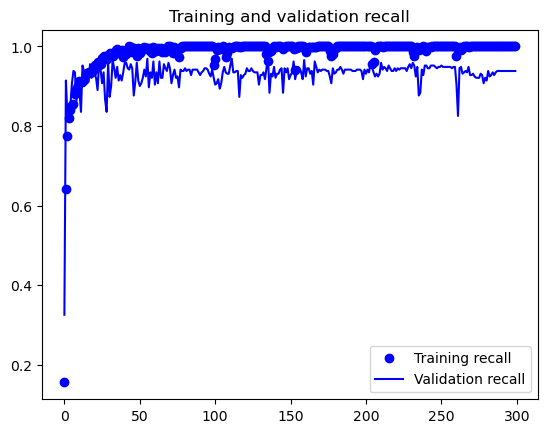

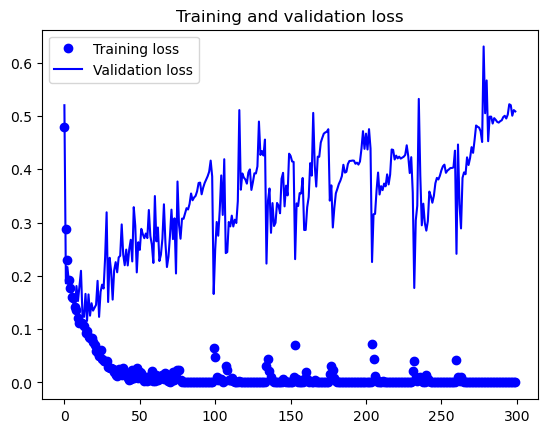

In [30]:
# 
import matplotlib.pyplot as plt
%matplotlib inline

rec = history.history['recall_1']
val_rec = history.history['val_recall_1']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(rec))

plt.plot(epochs, rec, 'bo', label= 'Training recall')
plt.plot(epochs, val_rec, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

The training recall and the validation recall still not converging. There are still an oscillation in the both, so as a next step I will try to increase the epochs and the layers.
The loss always going to fluctuate it can only improve if I compromise the recall, I will try to run it with a larger epoch size (300)

In [45]:
### Ridge regularization
reg = l2(3e-3)

In [46]:
# Initializing the CNN
model4 = Sequential()

# 1st convolution layer and pooling
model4.add(layers.Conv2D(64, (3, 3), input_shape=(200, 200, 1), activation = 'relu', kernel_regularizer = reg))
model4.add(MaxPooling2D(pool_size = (3, 3)))

# 2nd convolution layer and pooling
model4.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model4.add(MaxPooling2D(pool_size = (3, 3)))
model4.add(Dropout(0.2))

# 3rd 
model4.add(layers.Conv2D(32, (3,3), activation ='relu'))
model4.add(MaxPooling2D(pool_size = (3, 3)))

# plattening the layers
model4.add(Flatten())

# adding the fully connected dense layer
model4.add(Dense(32, activation = 'relu'))
#model2.add(Dropout(0.3))
# output layer
model4.add(Dense(1, activation = 'sigmoid'))

# compiler
model4.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=[recall()])

history = model2.fit(train_images,
                        train_y, # changed train_generator and added the train_y
                        batch_size = 32,
                        epochs = 200,
                        validation_data = (val_images, val_y))

Epoch 1/200
122/122 [==============================] - 3s 24ms/step - loss: 4.3107e-06 - recall_1: 1.0000 - val_loss: 0.5210 - val_recall_1: 0.9384
Epoch 2/200
122/122 [==============================] - 3s 23ms/step - loss: 3.4130e-06 - recall_1: 1.0000 - val_loss: 0.5267 - val_recall_1: 0.9349
Epoch 3/200
122/122 [==============================] - 3s 23ms/step - loss: 4.5294e-06 - recall_1: 1.0000 - val_loss: 0.5296 - val_recall_1: 0.9349
Epoch 4/200
122/122 [==============================] - 3s 23ms/step - loss: 2.1329e-06 - recall_1: 1.0000 - val_loss: 0.5258 - val_recall_1: 0.9384
Epoch 5/200
122/122 [==============================] - 3s 23ms/step - loss: 3.0531e-06 - recall_1: 1.0000 - val_loss: 0.5197 - val_recall_1: 0.9384
Epoch 6/200
122/122 [==============================] - 3s 23ms/step - loss: 5.1375e-06 - recall_1: 1.0000 - val_loss: 0.5138 - val_recall_1: 0.9384
Epoch 7/200
122/122 [==============================] - 3s 23ms/step - loss: 2.7825e-06 - recall_1: 1.0000 - val_

122/122 [==============================] - 3s 23ms/step - loss: 1.3235e-04 - recall_1: 1.0000 - val_loss: 0.4850 - val_recall_1: 0.9178
Epoch 57/200
122/122 [==============================] - 3s 23ms/step - loss: 9.5665e-05 - recall_1: 1.0000 - val_loss: 0.4201 - val_recall_1: 0.9384
Epoch 58/200
122/122 [==============================] - 3s 23ms/step - loss: 4.2181e-05 - recall_1: 1.0000 - val_loss: 0.4322 - val_recall_1: 0.9384
Epoch 59/200
122/122 [==============================] - 3s 23ms/step - loss: 7.5485e-05 - recall_1: 1.0000 - val_loss: 0.4440 - val_recall_1: 0.9384
Epoch 60/200
122/122 [==============================] - 3s 23ms/step - loss: 4.6906e-05 - recall_1: 1.0000 - val_loss: 0.4496 - val_recall_1: 0.9384
Epoch 61/200
122/122 [==============================] - 3s 23ms/step - loss: 3.7473e-05 - recall_1: 1.0000 - val_loss: 0.4467 - val_recall_1: 0.9384
Epoch 62/200
122/122 [==============================] - 3s 23ms/step - loss: 4.6519e-05 - recall_1: 1.0000 - val_loss: 

122/122 [==============================] - 3s 23ms/step - loss: 0.0011 - recall_1: 1.0000 - val_loss: 0.3746 - val_recall_1: 0.9418
Epoch 112/200
122/122 [==============================] - 3s 23ms/step - loss: 0.0101 - recall_1: 0.9929 - val_loss: 0.2991 - val_recall_1: 0.9144
Epoch 113/200
122/122 [==============================] - 3s 23ms/step - loss: 0.0027 - recall_1: 0.9976 - val_loss: 0.3057 - val_recall_1: 0.9452
Epoch 114/200
122/122 [==============================] - 3s 23ms/step - loss: 3.2985e-04 - recall_1: 1.0000 - val_loss: 0.3533 - val_recall_1: 0.9452
Epoch 115/200
122/122 [==============================] - 3s 23ms/step - loss: 3.8931e-04 - recall_1: 1.0000 - val_loss: 0.3604 - val_recall_1: 0.9418
Epoch 116/200
122/122 [==============================] - 3s 23ms/step - loss: 1.5959e-04 - recall_1: 1.0000 - val_loss: 0.3786 - val_recall_1: 0.9281
Epoch 117/200
122/122 [==============================] - 3s 23ms/step - loss: 3.4821e-04 - recall_1: 1.0000 - val_loss: 0.5043

122/122 [==============================] - 3s 23ms/step - loss: 2.4496e-06 - recall_1: 1.0000 - val_loss: 0.5406 - val_recall_1: 0.9349
Epoch 167/200
122/122 [==============================] - 3s 23ms/step - loss: 1.5950e-06 - recall_1: 1.0000 - val_loss: 0.5462 - val_recall_1: 0.9315
Epoch 168/200
122/122 [==============================] - 3s 23ms/step - loss: 2.9871e-06 - recall_1: 1.0000 - val_loss: 0.5448 - val_recall_1: 0.9281
Epoch 169/200
122/122 [==============================] - 3s 23ms/step - loss: 3.5951e-06 - recall_1: 1.0000 - val_loss: 0.5472 - val_recall_1: 0.9384
Epoch 170/200
122/122 [==============================] - 3s 23ms/step - loss: 5.4202e-06 - recall_1: 1.0000 - val_loss: 0.5525 - val_recall_1: 0.9349
Epoch 171/200
122/122 [==============================] - 3s 23ms/step - loss: 1.2872e-06 - recall_1: 1.0000 - val_loss: 0.5512 - val_recall_1: 0.9384
Epoch 172/200
122/122 [==============================] - 3s 23ms/step - loss: 9.7213e-07 - recall_1: 1.0000 - val_

In [47]:
results_train = model4.evaluate(train_images, train_y)
results_train

2022-12-07 12:50:31.060808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


122/122 [==============================] - 2s 16ms/step - loss: 0.7173 - recall_3: 1.0000


[0.7173438668251038, 1.0]

In [50]:
results_val = model4.evaluate(val_images, val_y)
results_val

23/23 [==============================] - 0s 15ms/step - loss: 0.7049 - recall_3: 1.0000


[0.7049397230148315, 1.0]

In [51]:
results_test = model4.evaluate(test_images, test_y)
results_test

39/39 [==============================] - 1s 13ms/step - loss: 0.7083 - recall_3: 1.0000


[0.7083287239074707, 1.0000001192092896]

In [ ]:
# confusion matrix 


### Data Augmentation

In [31]:
# generating more data with ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.3,
                                  zoom_range = 0.1,
                                  horizontal_flip=False)

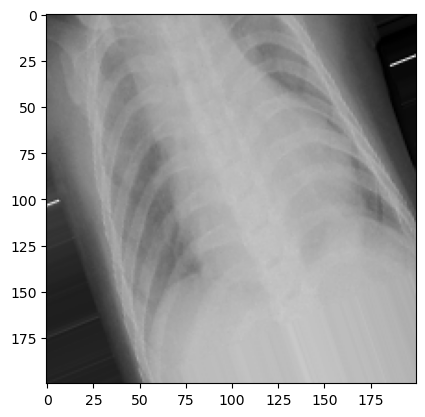

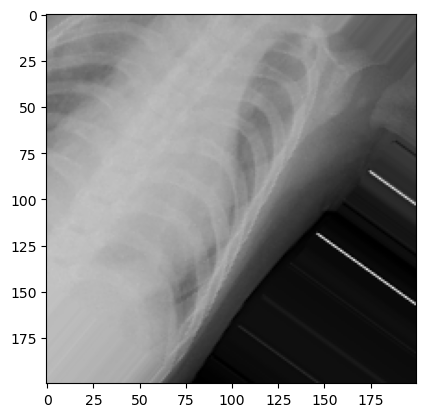

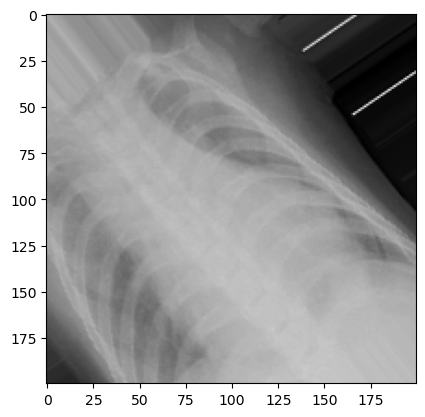

In [32]:
# show train_p augmentation 
names = [os.path.join(train_p, name) for name in os.listdir(train_p)]
img_path = names[91]
img = load_img(img_path, target_size = (200,200))

reshape_img = img_to_array(img)
reshape_img = reshape_img.reshape((1,) + reshape_img.shape)
i = 0
for batch in train_datagen.flow(reshape_img, batch_size = 1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break
plt.show()

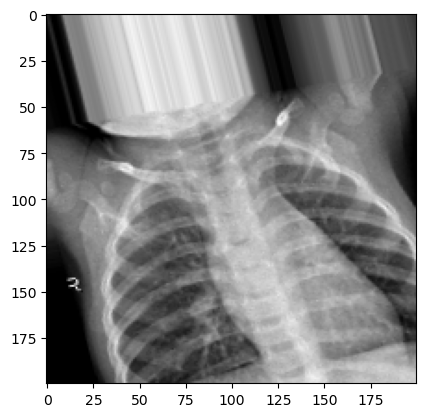

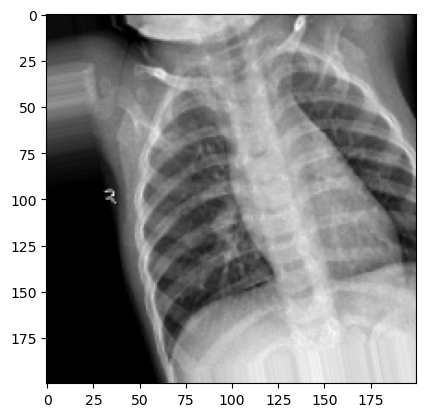

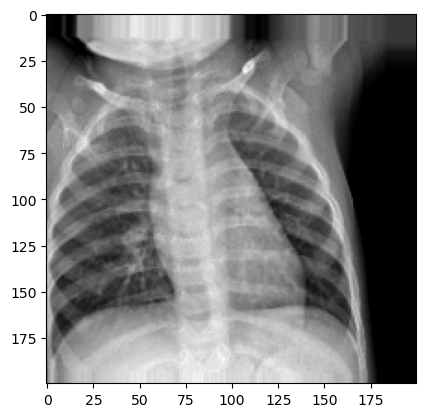

In [33]:
# train_n 
names = [os.path.join(train_n, name) for name in os.listdir(train_n)]
img_path = names[90]
img = load_img(img_path, target_size = (200,200))

reshape_img = img_to_array(img)
reshape_img = reshape_img.reshape((1,) + reshape_img.shape)
i = 0
for batch in train_datagen.flow(reshape_img, batch_size = 1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break
plt.show()

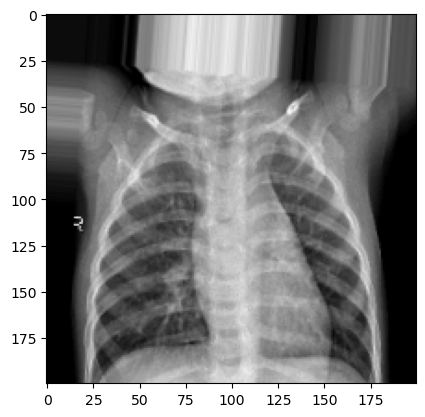

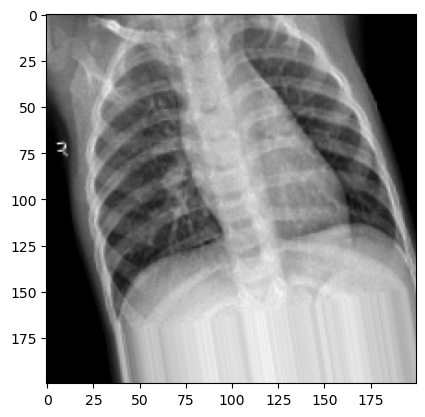

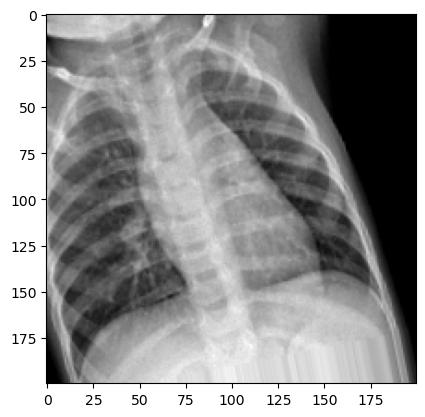

In [34]:
# test_p 
names = [os.path.join(test_p, name) for name in os.listdir(test_p)]
#img_path = names[92]
img = load_img(img_path, target_size = (200,200))

reshape_img = img_to_array(img)
reshape_img = reshape_img.reshape((1,) + reshape_img.shape)
i = 0
for batch in train_datagen.flow(reshape_img, batch_size = 1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break
plt.show()

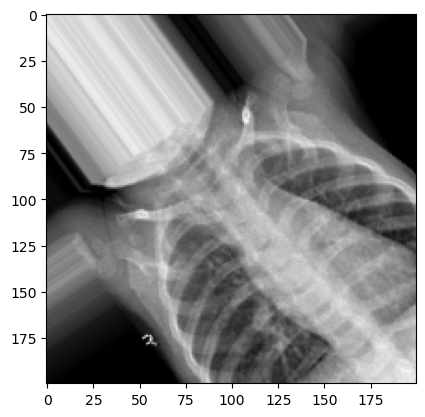

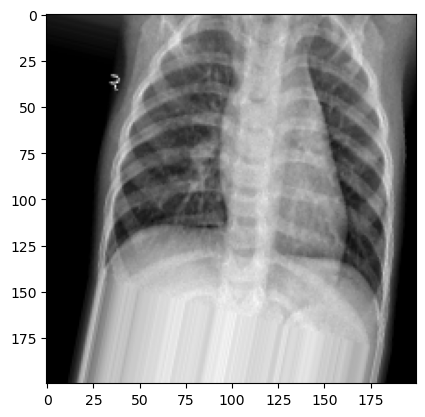

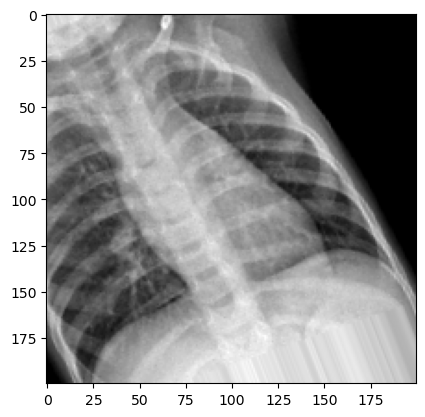

In [35]:
# test_p 
names = [os.path.join(test_n, name) for name in os.listdir(test_n)]
#img_path = names[92]
img = load_img(img_path, target_size = (200,200))

reshape_img = img_to_array(img)
reshape_img = reshape_img.reshape((1,) + reshape_img.shape)
i = 0
for batch in train_datagen.flow(reshape_img, batch_size = 1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break
plt.show()

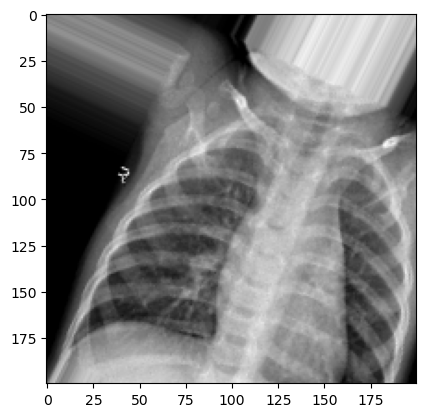

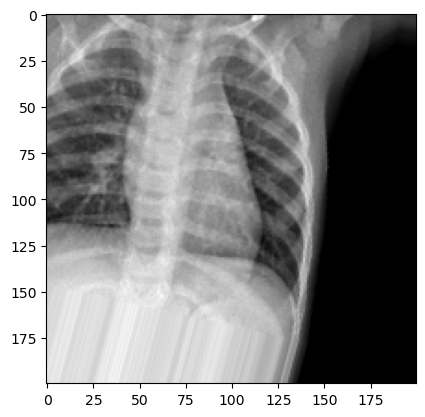

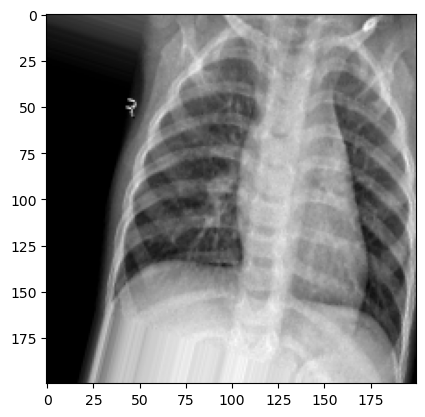

In [36]:
# test_p 
names = [os.path.join(val_p, name) for name in os.listdir(val_p)]
#img_path = names[92]
img = load_img(img_path, target_size = (200,200))

reshape_img = img_to_array(img)
reshape_img = reshape_img.reshape((1,) + reshape_img.shape)
i = 0
for batch in train_datagen.flow(reshape_img, batch_size = 1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break
plt.show()

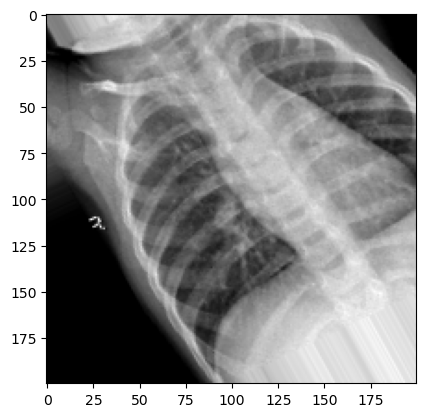

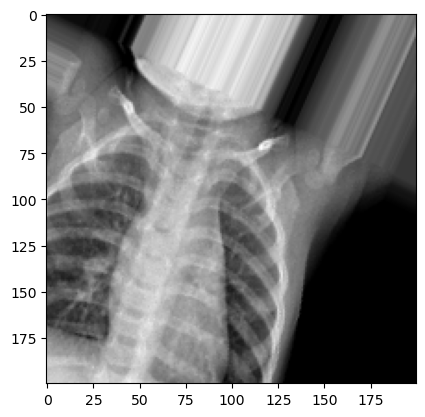

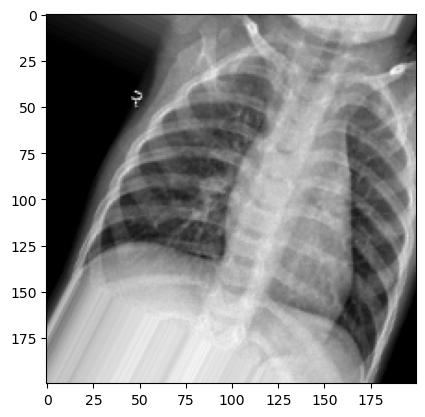

In [37]:
# test_p 
names = [os.path.join(val_n, name) for name in os.listdir(val_n)]
#img_path = names[92]
img = load_img(img_path, target_size = (200,200))

reshape_img = img_to_array(img)
reshape_img = reshape_img.reshape((1,) + reshape_img.shape)
i = 0
for batch in train_datagen.flow(reshape_img, batch_size = 1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break
plt.show()

In [38]:
#don't need this
# get all the data in the directory split/test (1234 images), and reshape them
test_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
    test_path,
    target_size = (200, 200), 
    batch_size = 1234,
    class_mode = 'binary')

# get all the data in the directory split/validation (721 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_path, 
    target_size=(200, 200), 
    batch_size = 721,
    class_mode = 'binary')

# get all the data in the directory split/train (3901 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_path, 
    target_size=(200, 200), 
    batch_size=3901,
    class_mode = 'binary')

Found 1234 images belonging to 2 classes.
Found 721 images belonging to 2 classes.
Found 3901 images belonging to 2 classes.


In [39]:
model3 = Sequential()
model3.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(200 ,200,  1)))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Conv2D(32, (4, 4), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy',
              optimizer= 'adam',
              metrics=[recall()])

In [40]:
history_2 = model3.fit(train_images,train_y, 
                                steps_per_epoch = 25,
                                epochs = 50,
                                validation_data = (val_images, val_y),
                                validation_steps = 25)

Epoch 1/50


2022-12-07 10:50:22.246483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - ETA: 0s - loss: 0.5035 - recall_2: 0.0717

2022-12-07 10:50:25.698892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 4s 122ms/step - loss: 0.5035 - recall_2: 0.0717 - val_loss: 0.4266 - val_recall_2: 0.4897
Epoch 2/50
25/25 [==============================] - 3s 108ms/step - loss: 0.3047 - recall_2: 0.6251 - val_loss: 0.2467 - val_recall_2: 0.7534
Epoch 3/50
25/25 [==============================] - 3s 107ms/step - loss: 0.2318 - recall_2: 0.7579 - val_loss: 0.2356 - val_recall_2: 0.8048
Epoch 4/50
25/25 [==============================] - 3s 106ms/step - loss: 0.2132 - recall_2: 0.7908 - val_loss: 0.1440 - val_recall_2: 0.9897
Epoch 5/50
25/25 [==============================] - 3s 106ms/step - loss: 0.1789 - recall_2: 0.8226 - val_loss: 0.1241 - val_recall_2: 0.9041
Epoch 6/50
25/25 [==============================] - 3s 107ms/step - loss: 0.1467 - recall_2: 0.8754 - val_loss: 0.2095 - val_recall_2: 0.8390
Epoch 7/50
25/25 [==============================] - 3s 107ms/step - loss: 0.1753 - recall_2: 0.8061 - val_loss: 0.1455 - val_recall_2: 0.8938
Epoch 8/50
25/25 

In [42]:
results_train = model3.evaluate(train_images, train_y)
results_train

122/122 [==============================] - 2s 14ms/step - loss: 1.2698e-04 - recall_2: 1.0000


[0.00012698289356194437, 1.0]

In [43]:
results_train = model3.evaluate(val_images, val_y)
results_train

23/23 [==============================] - 0s 15ms/step - loss: 0.2472 - recall_2: 0.9452


[0.2472078651189804, 0.9452054500579834]

In [44]:
results_train = model3.evaluate(test_images, test_y)
results_train

39/39 [==============================] - 1s 14ms/step - loss: 0.8548 - recall_2: 0.7795


[0.8548152446746826, 0.7795454859733582]

In [41]:
# define the stakeholders 